In [1]:
import sys
sys.version

'3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]'

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 41.1 MB/s eta 0:00:00


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors

mol = Chem.MolFromSmiles("CCO")
Descriptors.MolWt(mol)

46.069

In [4]:
from google.colab import files

uploaded = files.upload()

Saving curated_bioactivity_data.csv to curated_bioactivity_data (1).csv


In [5]:
import pandas as pd

df = pd.read_csv("curated_bioactivity_data.csv")
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,nM,=
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,nM,=
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,nM,=
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,nM,=
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,2400.0,nM,=


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7522 entries, 0 to 7521
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  7522 non-null   object 
 1   canonical_smiles    7522 non-null   object 
 2   standard_value      7522 non-null   float64
 3   standard_units      7522 non-null   object 
 4   standard_relation   7522 non-null   object 
dtypes: float64(1), object(4)
memory usage: 294.0+ KB


,standard_value
count,7.522000e+03
mean,8.006118e+04
std,8.240937e+05
min,0.000000e+00
25%,7.900000e+01
50%,9.100000e+02
75%,8.300000e+03
max,4.960000e+07


In [7]:
df = df.dropna(subset=["canonical_smiles"])
df.shape

(7522, 5)

In [8]:
df["Mol"] = df["canonical_smiles"].apply(Chem.MolFromSmiles)
df = df[df["Mol"].notnull()]
df.shape

(7522, 6)

In [10]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [11]:
def lipinski_descriptors(mol):
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "H_Donors": Lipinski.NumHDonors(mol),
        "H_Acceptors": Lipinski.NumHAcceptors(mol)
    })

lipinski_df = df["Mol"].apply(lipinski_descriptors)
lipinski_df.head()

,MolWt,LogP,H_Donors,H_Acceptors
0,312.325,2.80320,0.0,5.0
1,376.913,4.55460,0.0,4.0
2,404.845,4.70690,0.0,4.0
3,346.334,3.09530,0.0,5.0
4,338.436,4.07992,0.0,4.0


In [12]:
df_lipinski = pd.concat([df, lipinski_df], axis=1)
df_lipinski.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,Mol,MolWt,LogP,H_Donors,H_Acceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,nM,=,<rdkit.Chem.rdchem.Mol object at 0x7fd186118e40>,312.325,2.80320,0.0,5.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,nM,=,<rdkit.Chem.rdchem.Mol object at 0x7fd186119380>,376.913,4.55460,0.0,4.0
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,nM,=,<rdkit.Chem.rdchem.Mol object at 0x7fd1861192a0>,404.845,4.70690,0.0,4.0
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,nM,=,<rdkit.Chem.rdchem.Mol object at 0x7fd186119310>,346.334,3.09530,0.0,5.0
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,2400.0,nM,=,<rdkit.Chem.rdchem.Mol object at 0x7fd186119230>,338.436,4.07992,0.0,4.0


In [13]:
df_lipinski.to_csv("lipinski_descriptors.csv", index=False)

In [14]:
from google.colab import files
files.download("lipinski_descriptors.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

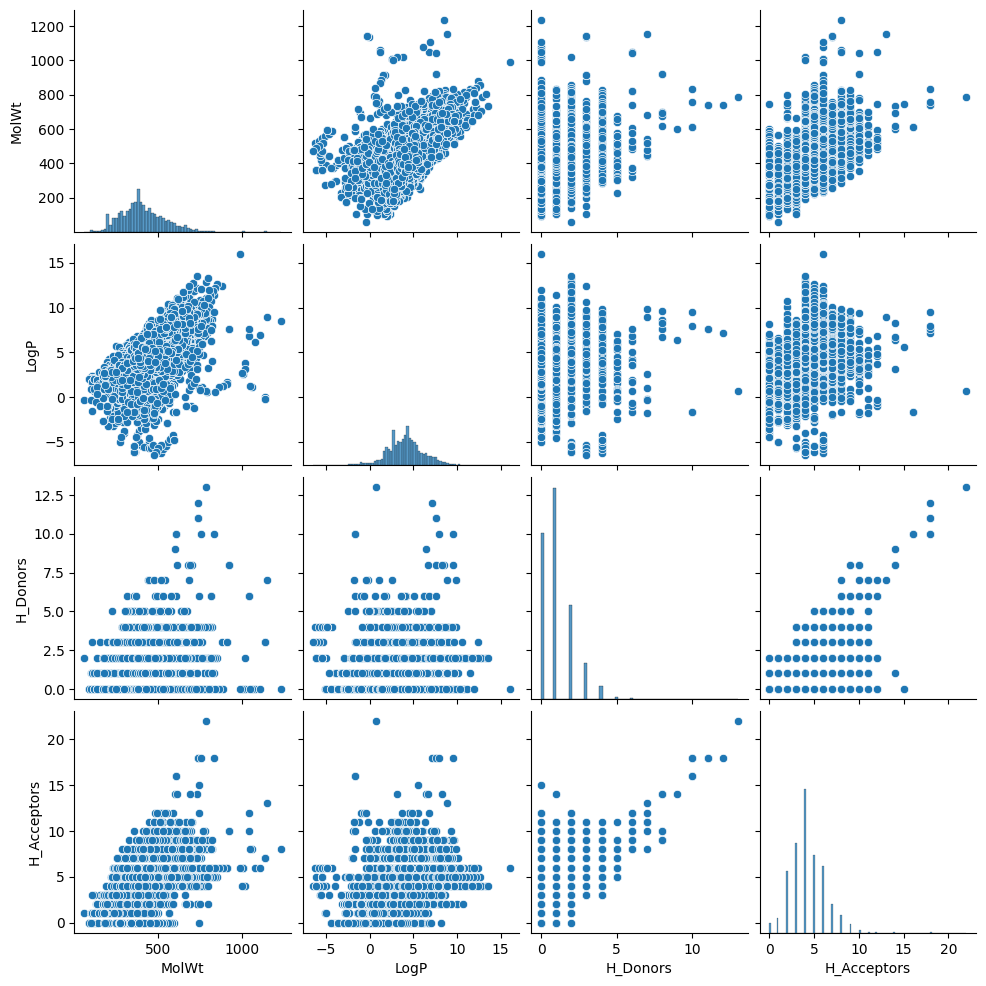

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_lipinski[["MolWt", "LogP", "H_Donors", "H_Acceptors"]])
plt.show()

In [16]:
from rdkit.Chem import AllChem

def morgan_fp(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

fps = df_lipinski["Mol"].apply(morgan_fp)

Streaming output truncated to the last 5000 lines.
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:26:44] DEPRECATION WARNING: please use MorganGenerator
[17:2

In [17]:
fp_df = pd.DataFrame([list(fp) for fp in fps])
fp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
fp_df.to_csv("morgan_fingerprints.csv", index=False)
files.download("morgan_fingerprints.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
df_lipinski[["MolWt", "LogP", "H_Donors", "H_Acceptors"]].describe()

,MolWt,LogP,H_Donors,H_Acceptors
count,7522.000000,7522.000000,7522.000000,7522.000000
mean,408.721027,4.072462,1.126163,4.295932
std,131.971853,2.342185,1.132803,1.967603
min,61.040000,-6.532800,0.000000,0.000000
25%,321.389750,2.704400,0.000000,3.000000
50%,392.470000,4.117200,1.000000,4.000000
75%,485.486500,5.335785,2.000000,5.000000
max,1235.463000,16.026400,13.000000,22.000000
